# Panel de desviaciones de alertas de fraude

**Objetivo general:**  
Construir un sistema de detección de anomalías sobre alertas de fraude (cantidad de alertas y clientes únicos por tipo de alerta) que permita generar un score de criticidad (normal / media / crítica) e integrarse posteriormente a un pipeline en AWS.

Este notebook corresponde a la fase de:
- Análisis exploratorio de datos (EDA)
- Selección y comparación de técnicas
- Entrenamiento y evaluación de modelos (RandomForest, MLP, LSTM)


In [78]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import textwrap

from scipy.stats.mstats import winsorize
from pandas import Grouper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve, classification_report,average_precision_score
)
from sklearn.ensemble import IsolationForest
from tensorflow.keras import layers, models, optimizers


# Paleta de colores
color_burdeo      = "#800020"
color_steel_blue  = "#4682B4"
color_verde_lima  = "#C7EA46"

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)


In [2]:
DATA_PATH = "data_set.csv"

df = pd.read_csv(DATA_PATH)

print("Dimensiones del dataset (filas, columnas):", df.shape)
display(df.head())

print("\nInformación de tipos de datos:")
display(df.info())

print("\nResumen numérico:")
display(df.describe())


Dimensiones del dataset (filas, columnas): (636166, 6)


,ID,rule_name,FECHA_CREACION,HORA_CREACION,TIPO,token_rut
0,APP-26-967322,-,13-07-2025,11:34:29,AUTOMATICA,9D04B9
1,APP-36-15112,-,13-07-2025,11:33:34,AUTOMATICA,C5D5A6
2,9344792825,ALERT GOOGLE,13-07-2025,11:32:00,AUTOMATICA,EF6D5D
3,9344794391,ALERT GOOGLE,13-07-2025,11:32:00,AUTOMATICA,EF6D5D
4,9344786173,CC ALERTA BILLETERA DATE TOKEN,13-07-2025,11:32:00,AUTOMATICA,6B34D3



Información de tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636166 entries, 0 to 636165
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              636166 non-null  object
 1   rule_name       636166 non-null  object
 2   FECHA_CREACION  636166 non-null  object
 3   HORA_CREACION   636166 non-null  object
 4   TIPO            636166 non-null  object
 5   token_rut       636166 non-null  object
dtypes: object(6)
memory usage: 29.1+ MB


None


Resumen numérico:


,ID,rule_name,FECHA_CREACION,HORA_CREACION,TIPO,token_rut
count,636166,636166,636166,636166,636166,636166
unique,635914,51,303,58515,2,369124
top,BTO-1-18435,-,06-10-2025,16:28:00,AUTOMATICA,D712F4
freq,10,390764,13602,1238,582054,595


In [3]:
# Limpieza de textos en columnas clave
cols_texto = ['rule_name', 'ID', 'token_rut', 'TIPO']
for c in cols_texto:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.upper()
    else:
        print(f"[ADVERTENCIA] La columna '{c}' no se encuentra en el dataset.")

# Normalización de nombres de reglas (RULE_NORM)
map_rulename = {
    'OS_WPP_WEB RECAUDA.3ROS HITES': 'OS_WPP_WEB_RECAUDA.3ROS_HITES',
    'OS_WEBPAY_WEB LIDER.CL':        'OS_WEBPAY_WEB_LIDER.CL',
    'OS_WEBPAY HITES':               'OS_WEBPAY_HITES',
    'OS_WEBPAY WEB PAGADOOR':        'OS_WEBPAY_WEB_PAGADOOR',
    'OS_WEBPAY PRONTO PAGA':         'OS_WEBPAY_PRONTO_PAGA',
    'ALERT GOOGLE':                  'ALERT_GOOGLE',
    'ALERTA BILLETERA BE PAY':       'ALERTA_BILLETERA_BE_PAY',
    'CC S.ALERTA BILLETERA DATE TOKEN': 'CC_S.ALERTA_BILLETERA_DATE_TOKEN',
    'CC BLOQ TARJETA FUERZA BRUTA':  'CC_BLOQ_TARJETA_FUERZA_BRUTA',
    'OS_WEBPAY_WEB LIDER ONE CLICK': 'OS_WEBPAY_WEB_LIDER_ONE_CLICK',
    'OS_WEBPAY LIDER ONE CLICK':     'OS_WEBPAY_WEB_LIDER_ONE_CLICK',
    'CC CCIO PRUEBA BANDA':          'CC_CCIO_PRUEBA_BANDA',
    'CC ECOMMERCE SCORE ALTO':       'CC_ECOMMERCE_SCORE_ALTO',
    'CC FACEBOOK 2.0':               'CC_FACEBOOK_2.0',
    'CC LC ALERT POR MONTO':         'CC_LC_ALERT_POR_MONTO',
    'CC VALIDA PRIM. TRX MP WALLET': 'CC_VALIDA_PRIM._TRX_MP_WALLET',
    'CC SUPLANTACION 3DS':           'CC_SUPLANTACION_3DS',
    'CC TX CONSECUTIVA ECOMMERCE':   'CC_TX_CONSECUTIVA_ECOMMERCE',
    'CC TX PARALELAS NAC INT':       'CC_TX_PARALELAS_NAC_INT',
    'OS WEB MONEYGRAM PAYMENT':      'OS_WEB_MONEYGRAM_PAYMENT',
    'OS WEB PK COMERCIOS EN LINEA':  'OS_WEB_PK_COMERCIOS_EN_LINEA',
    'OS WEBPAY AFEX':                'OS_WEBPAY_AFEX',
    'CC PILOTO SCORE VAAI':          'CC_PILOTO_SCORE_VAAI',
    'OS WEBPAY ALPS Y NUVEI':        'OS_WEBPAY_ALPS_Y_NUVEI'
}

df['RULE_NORM'] = df['rule_name'].map(map_rulename).fillna(df['rule_name'])
df['RULE_NORM'] = (df['RULE_NORM']
                   .str.replace(" ", "_", regex=False)
                   .str.replace("__+", "_", regex=True))

# Construcción de variable ALERTA
id_str = df['ID'].astype(str).str.strip()
mask_num = id_str.str.fullmatch(r"\d+")
prefijo_id = id_str.str.extract(r"^([^-\s]+-[^-]+)", expand=False)

df['ALERTA'] = np.where(mask_num, df['RULE_NORM'], prefijo_id.fillna(df['RULE_NORM']))
df['ALERTA'] = (df['ALERTA']
                .str.replace(" ", "_", regex=False)
                .str.replace("__+", "_", regex=True))

# Identificador numérico de cliente
df['CLIENTE_ID'] = df['token_rut'].astype('category').cat.codes.astype('int64')

# Construcción de fecha-hora de la alerta
df['FECHA_ALERTA'] = pd.to_datetime(
    df['FECHA_CREACION'].astype(str) + " " + df['HORA_CREACION'].astype(str),
    format="%d-%m-%Y %H:%M:%S",
    errors='coerce'
)

#  Codificación numérica de tipo de alerta
df['TIPO_N'] = df['TIPO'].map({'MANUAL': 1, 'AUTOMATICA': 2}).astype('int64')

print("Dataset normalizado : \n")
print("\n")
display(df.head())

print("\nValores nulos por columna:")
display(df.isna().sum())


Dataset normalizado : 





,ID,rule_name,FECHA_CREACION,HORA_CREACION,TIPO,token_rut,RULE_NORM,ALERTA,CLIENTE_ID,FECHA_ALERTA,TIPO_N
0,APP-26-967322,-,13-07-2025,11:34:29,AUTOMATICA,9D04B9,-,APP-26,226330,2025-07-13 11:34:29,2
1,APP-36-15112,-,13-07-2025,11:33:34,AUTOMATICA,C5D5A6,-,APP-36,285238,2025-07-13 11:33:34,2
2,9344792825,ALERT GOOGLE,13-07-2025,11:32:00,AUTOMATICA,EF6D5D,ALERT_GOOGLE,ALERT_GOOGLE,345244,2025-07-13 11:32:00,2
3,9344794391,ALERT GOOGLE,13-07-2025,11:32:00,AUTOMATICA,EF6D5D,ALERT_GOOGLE,ALERT_GOOGLE,345244,2025-07-13 11:32:00,2
4,9344786173,CC ALERTA BILLETERA DATE TOKEN,13-07-2025,11:32:00,AUTOMATICA,6B34D3,CC_ALERTA_BILLETERA_DATE_TOKEN,CC_ALERTA_BILLETERA_DATE_TOKEN,154086,2025-07-13 11:32:00,2



Valores nulos por columna:


ID                0
rule_name         0
FECHA_CREACION    0
HORA_CREACION     0
TIPO              0
token_rut         0
RULE_NORM         0
ALERTA            0
CLIENTE_ID        0
FECHA_ALERTA      0
TIPO_N            0
dtype: int64

In [4]:
def build_agg_by_freq(df, freq='D'):
    """
    Construye un dataset agregado por ALERTA y FECHA_ALERTA
    con la frecuencia indicada.

    freq:
        'D'   =  diario
        'W-SUN' = semanal (semanas que terminan el domingo)
        'M'   = mensual
    """
    agg = (
        df.groupby(['ALERTA', Grouper(key='FECHA_ALERTA', freq=freq)])
          .agg(
              CANTIDAD_ALERTA=('ID', 'count'),
              TOTAL_CLIENTES =('CLIENTE_ID', 'count'),
              CLIENTES_UNICOS=('CLIENTE_ID', 'nunique'),
              TIPO_PROM      =('TIPO_N', 'mean')  
          )
          .reset_index()
          .rename(columns={'FECHA_ALERTA': 'FECHA'})
    )

    # Casteo a int
    agg['CANTIDAD_ALERTA'] = agg['CANTIDAD_ALERTA'].astype('int64')
    agg['TOTAL_CLIENTES']  = agg['TOTAL_CLIENTES'].astype('int64')
    agg['CLIENTES_UNICOS'] = agg['CLIENTES_UNICOS'].astype('int64')

    # Tipo dominante: si promedio >= 1.5 => mayoria automaticas (2), si no manuales (1)
    agg['TIPO'] = np.where(agg['TIPO_PROM'] >= 1.5, 2, 1).astype('int64')
    agg = agg.drop(columns=['TIPO_PROM'])

    # guardar la frecuencia como texto para rastrear el origen
    agg['FRECUENCIA'] = freq

    return agg

# Agregado diario
df_diario =  build_agg_by_freq(df, freq='D')
df_daily = build_agg_by_freq(df, freq='D')

# Agregado semanal
df_semanal = build_agg_by_freq(df, freq='W-SUN')
df_weekly = build_agg_by_freq(df, freq='W-SUN')

# Agregado mensual (fin de mes)
df_mensual= build_agg_by_freq(df, freq='M')
df_monthly = build_agg_by_freq(df, freq='M')

print("Agregado diario : \n")
display(df_daily.head())
print("\n")

print("Agregado semanal : \n")
display(df_weekly.head())
print("\n")

print("Agregado mensual : \n")
display(df_monthly.head())
print("\n")


Agregado diario : 



,ALERTA,FECHA,CANTIDAD_ALERTA,TOTAL_CLIENTES,CLIENTES_UNICOS,TIPO,FRECUENCIA
0,ALERTA_BILLETERA_BE_PAY,2025-01-01,2,2,1,2,D
1,ALERTA_BILLETERA_BE_PAY,2025-01-04,1,1,1,2,D
2,ALERTA_BILLETERA_BE_PAY,2025-01-05,1,1,1,2,D
3,ALERTA_BILLETERA_BE_PAY,2025-01-06,4,4,3,2,D
4,ALERTA_BILLETERA_BE_PAY,2025-01-07,2,2,1,2,D




Agregado semanal : 



,ALERTA,FECHA,CANTIDAD_ALERTA,TOTAL_CLIENTES,CLIENTES_UNICOS,TIPO,FRECUENCIA
0,ALERTA_BILLETERA_BE_PAY,2025-01-05,4,4,3,2,W-SUN
1,ALERTA_BILLETERA_BE_PAY,2025-01-12,6,6,4,2,W-SUN
2,ALERTA_BILLETERA_BE_PAY,2025-01-19,5,5,3,2,W-SUN
3,ALERTA_BILLETERA_BE_PAY,2025-01-26,1,1,1,2,W-SUN
4,ALERTA_BILLETERA_BE_PAY,2025-02-02,1,1,1,2,W-SUN




Agregado mensual : 



,ALERTA,FECHA,CANTIDAD_ALERTA,TOTAL_CLIENTES,CLIENTES_UNICOS,TIPO,FRECUENCIA
0,ALERTA_BILLETERA_BE_PAY,2025-01-31,17,17,12,2,M
1,ALERTA_BILLETERA_BE_PAY,2025-02-28,13,13,9,2,M
2,ALERTA_BILLETERA_BE_PAY,2025-03-31,18,18,11,2,M
3,ALERTA_BILLETERA_BE_PAY,2025-04-30,6,6,5,2,M
4,ALERTA_BILLETERA_BE_PAY,2025-05-31,13,13,7,2,M


In [5]:
print("Valores faltantes (conteo):")
display(df.isna().sum().sort_values(ascending=False))

print("\nValores faltantes (%):")
display((df.isna().mean() * 100).sort_values(ascending=False))

print("\nFilas duplicadas en DF base:", df.duplicated().sum())

cat_cols = df.select_dtypes(include=['object', 'category']).columns
print("\nCardinalidad de variables categóricas:")
for col in cat_cols:
    print(f"- {col}: {df[col].nunique()} valores únicos")
    print(df[col].value_counts().head(), "\n")


Valores faltantes (conteo):


ID                0
rule_name         0
FECHA_CREACION    0
HORA_CREACION     0
TIPO              0
token_rut         0
RULE_NORM         0
ALERTA            0
CLIENTE_ID        0
FECHA_ALERTA      0
TIPO_N            0
dtype: int64


Valores faltantes (%):


ID                0.0
rule_name         0.0
FECHA_CREACION    0.0
HORA_CREACION     0.0
TIPO              0.0
token_rut         0.0
RULE_NORM         0.0
ALERTA            0.0
CLIENTE_ID        0.0
FECHA_ALERTA      0.0
TIPO_N            0.0
dtype: float64


Filas duplicadas en DF base: 83

Cardinalidad de variables categóricas:
- ID: 635914 valores únicos
ID
BTO-1-18435     10
BTO-1-18414     10
BTO-1-18046      9
BTO-07-22902     8
BTO-1-18323      8
Name: count, dtype: int64 

- rule_name: 51 valores únicos
rule_name
-                                 390764
CC_COMERCIOS_WEBPAY                41181
ALERT_GOOGLE                       25987
CC ALERTA BILLETERA DATE TOKEN     24123
CC_BLOQ_TARJETA_FUERZA_BRUTA       24092
Name: count, dtype: int64 

- FECHA_CREACION: 303 valores únicos
FECHA_CREACION
06-10-2025    13602
07-10-2025     9797
26-06-2025     7782
30-09-2025     7134
08-10-2025     6002
Name: count, dtype: int64 

- HORA_CREACION: 58515 valores únicos
HORA_CREACION
16:28:00    1238
15:04:00    1234
18:32:00    1216
18:24:00    1208
19:28:00    1205
Name: count, dtype: int64 

- TIPO: 2 valores únicos
TIPO
AUTOMATICA    582054
MANUAL         54112
Name: count, dtype: int64 

- token_rut: 369124 valores únicos
token_rut
D712F4   

In [7]:
# Eliminación de duplicados
print("Filas antes de drop_duplicates:", df.shape[0])
df = df.drop_duplicates()
print("Filas después de drop_duplicates:", df.shape[0])

Filas antes de drop_duplicates: 636166
Filas después de drop_duplicates: 636083


In [6]:
cols_metricas = ['CANTIDAD_ALERTA', 'TOTAL_CLIENTES', 'CLIENTES_UNICOS']

def metricas_globales(df, nombre=""):
    print(f"\nMétricas globales ({nombre})")
    display(df[cols_metricas].agg(['mean', 'var', 'std', 'min', 'max']))

metricas_globales(df_daily, "Diario")
metricas_globales(df_weekly, "Semanal")
metricas_globales(df_monthly, "Mensual")



Métricas globales (Diario)


,CANTIDAD_ALERTA,TOTAL_CLIENTES,CLIENTES_UNICOS
mean,43.650748,43.650748,34.495609
var,19534.953291,19534.953291,11026.911221
std,139.767497,139.767497,105.009101
min,1.000000,1.000000,1.000000
max,7950.000000,7950.000000,6740.000000



Métricas globales (Semanal)


,CANTIDAD_ALERTA,TOTAL_CLIENTES,CLIENTES_UNICOS
mean,251.747527,251.747527,184.471310
var,485918.830135,485918.830135,186977.356164
std,697.078783,697.078783,432.408784
min,1.000000,1.000000,1.000000
max,13135.000000,13135.000000,11063.000000



Métricas globales (Mensual)


,CANTIDAD_ALERTA,TOTAL_CLIENTES,CLIENTES_UNICOS
mean,9.955649e+02,9.955649e+02,6.953239e+02
var,5.746568e+06,5.746568e+06,1.933916e+06
std,2.397200e+03,2.397200e+03,1.390653e+03
min,1.000000e+00,1.000000e+00,1.000000e+00
max,3.369900e+04,3.369900e+04,1.501800e+04


In [8]:
from scipy.stats.mstats import winsorize

df_daily["CANTIDAD_ALERTA_WIN"] = winsorize(
    df_daily["CANTIDAD_ALERTA"], limits=[0.05, 0.05]
)

df_daily["CLIENTES_UNICOS_WIN"] = winsorize(
    df_daily["CLIENTES_UNICOS"], limits=[0.05, 0.05]
)

df_daily["TOTAL_CLIENTES_WIN"] = winsorize(
    df_daily["TOTAL_CLIENTES"], limits=[0.05, 0.05]
)

print("Columnas winsorizadas creadas:")
df_daily[["CANTIDAD_ALERTA_WIN", "CLIENTES_UNICOS_WIN", "TOTAL_CLIENTES_WIN"]].head()


Columnas winsorizadas creadas:


,CANTIDAD_ALERTA_WIN,CLIENTES_UNICOS_WIN,TOTAL_CLIENTES_WIN
0,2,1,2
1,1,1,1
2,1,1,1
3,4,3,4
4,2,1,2


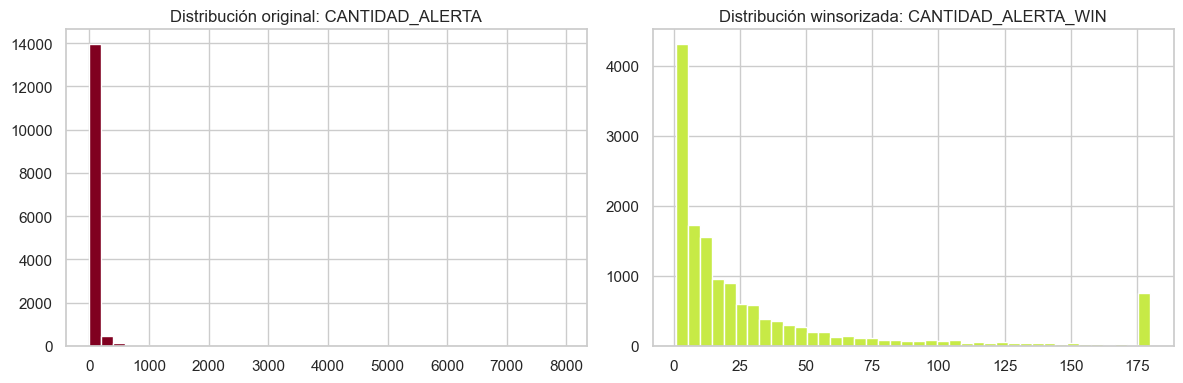

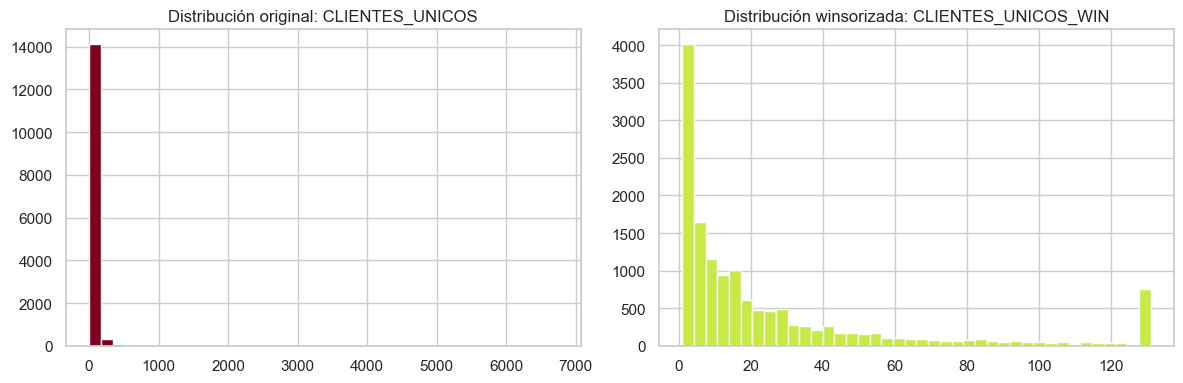

In [11]:
def plot_pre_post(df, var_orig, var_win, bins=40):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].hist(df[var_orig].dropna(), bins=bins, color = color_burdeo)
    axes[0].set_title(f"Distribución original: {var_orig}")
    
    axes[1].hist(df[var_win].dropna(), bins=bins, color= color_verde_lima)
    axes[1].set_title(f"Distribución winsorizada: {var_win}")
    
    plt.tight_layout()
    plt.show()

plot_pre_post(df_daily, "CANTIDAD_ALERTA", "CANTIDAD_ALERTA_WIN")
plot_pre_post(df_daily, "CLIENTES_UNICOS", "CLIENTES_UNICOS_WIN")


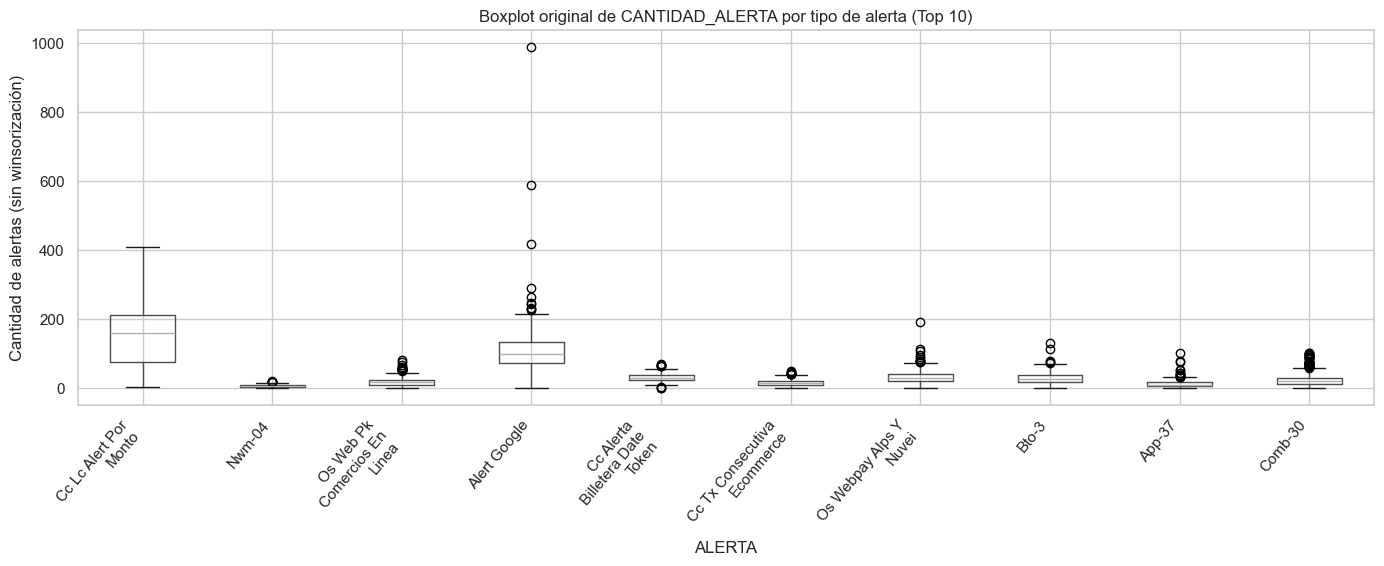

In [18]:
# Top 10 tipos de alerta
top_alertas = (
    df_daily["ALERTA"]
    .value_counts()
    .head(10)
    .index
)

df_top = df_daily[df_daily["ALERTA"].isin(top_alertas)]

def format_label(label, width=18):
    clean = label.replace("_", " ")
    clean = " ".join(clean.split())
    clean = clean.title()
    wrapped = textwrap.fill(clean, width)
    return wrapped

formatted_labels = [format_label(lbl, width=17) for lbl in top_alertas]

# BOXPLOT ORIGINAL 
fig, ax = plt.subplots(figsize=(14, 6))

df_top.boxplot(
    column="CANTIDAD_ALERTA",    
    by="ALERTA",
    ax=ax
)

ax.set_title("Boxplot original de CANTIDAD_ALERTA por tipo de alerta (Top 10)")
fig.suptitle("")
ax.set_ylabel("Cantidad de alertas (sin winsorización)")
ax.set_xticklabels(formatted_labels, rotation=50, ha="right")

plt.tight_layout()
plt.show()


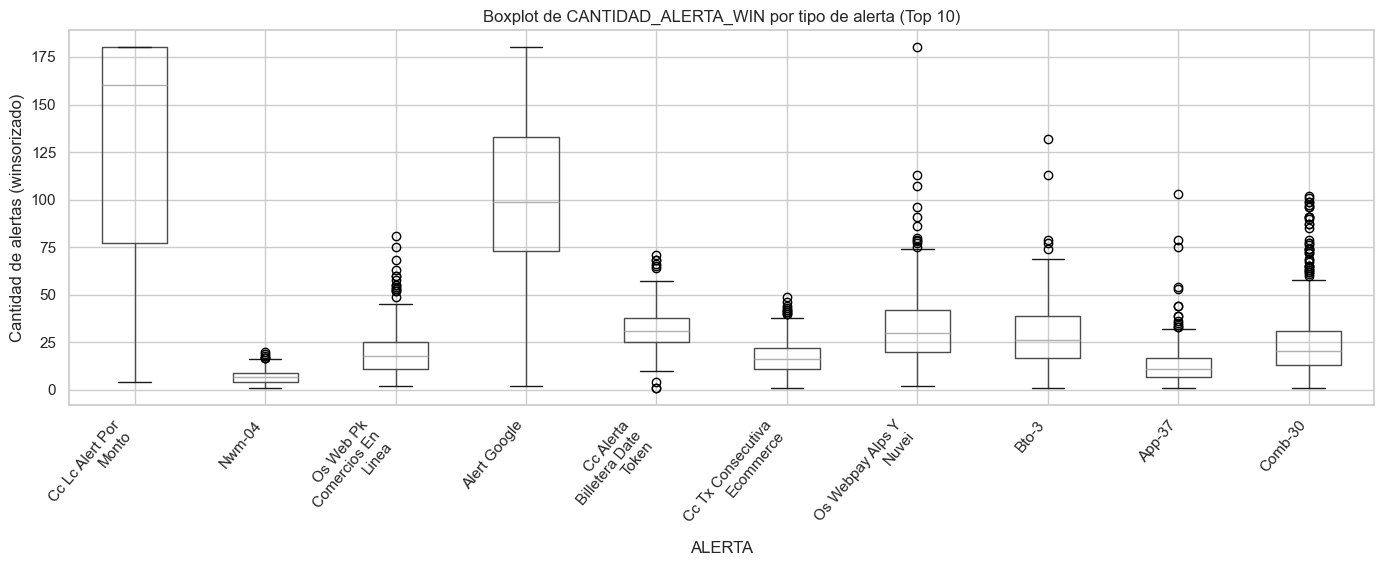

In [16]:
# Top 10 alertas
top_alertas = (
    df_daily["ALERTA"]
    .value_counts()
    .head(10)
    .index
)

df_top = df_daily[df_daily["ALERTA"].isin(top_alertas)]

# Función para limpiar y formatear nombres
def format_label(label, width=18):
    clean = label.replace("_", " ")               # reemplaza guiones bajos
    clean = " ".join(clean.split())               # elimina espacios dobles
    clean = clean.title()                         # opcional: título estilizado
    wrapped = textwrap.fill(clean, width)         # ajusta a varias líneas
    return wrapped

formatted_labels = [format_label(lbl, width=17) for lbl in top_alertas]

# Graficar
fig, ax = plt.subplots(figsize=(14, 6))

df_top.boxplot(
    column="CANTIDAD_ALERTA_WIN",
    by="ALERTA",
    ax=ax
)

ax.set_title("Boxplot de CANTIDAD_ALERTA_WIN por tipo de alerta (Top 10)")
fig.suptitle("")
ax.set_ylabel("Cantidad de alertas (winsorizado)")

# Aplicar labels formateados
ax.set_xticklabels(formatted_labels, rotation=50, ha="right")

plt.tight_layout()
plt.show()

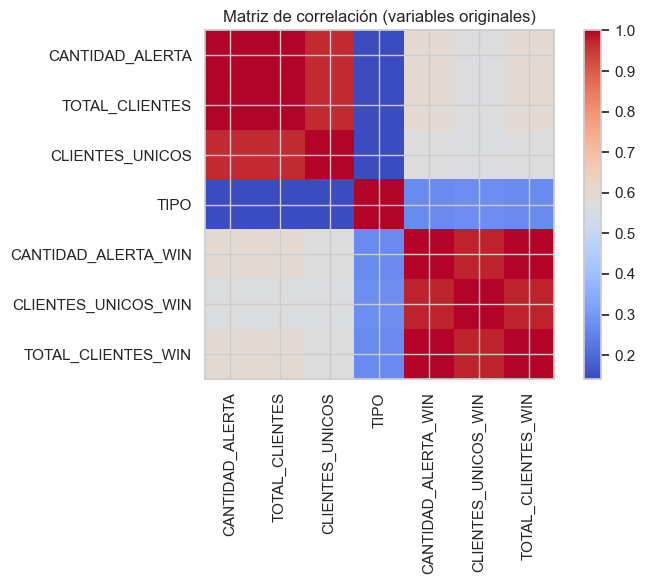

In [21]:
num_cols_orig = df_daily.select_dtypes(include=[np.number]).columns
corr_orig = df_daily[num_cols_orig].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr_orig, interpolation='nearest', cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(num_cols_orig)), num_cols_orig, rotation=90)
plt.yticks(range(len(num_cols_orig)), num_cols_orig)
plt.title("Matriz de correlación (variables originales)")
plt.tight_layout()
plt.show()

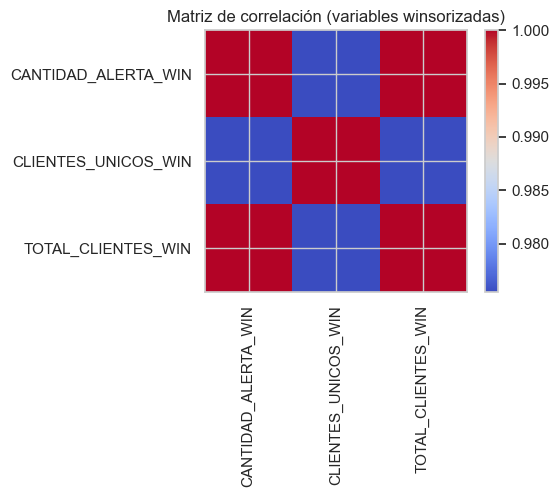

In [22]:
num_cols_win = ["CANTIDAD_ALERTA_WIN", "CLIENTES_UNICOS_WIN", "TOTAL_CLIENTES_WIN"]
corr_win = df_daily[num_cols_win].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr_win, interpolation='nearest', cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(num_cols_win)), num_cols_win, rotation=90)
plt.yticks(range(len(num_cols_win)), num_cols_win)
plt.title("Matriz de correlación (variables winsorizadas)")
plt.tight_layout()
plt.show()


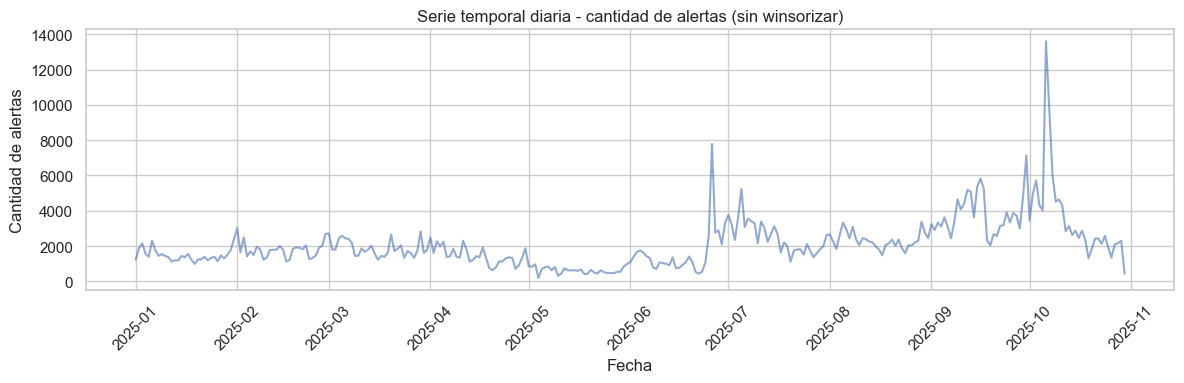

In [41]:
df_diario["FECHA"] = pd.to_datetime(df_diario["FECHA"])
serie_alertas_orig = (
    df_diario
    .groupby("FECHA")["CANTIDAD_ALERTA"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,4))
plt.plot(
    serie_alertas_orig["FECHA"],
    serie_alertas_orig["CANTIDAD_ALERTA"],
    label="Original",
    alpha=0.6
)
plt.title("Serie temporal diaria - cantidad de alertas (sin winsorizar)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de alertas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


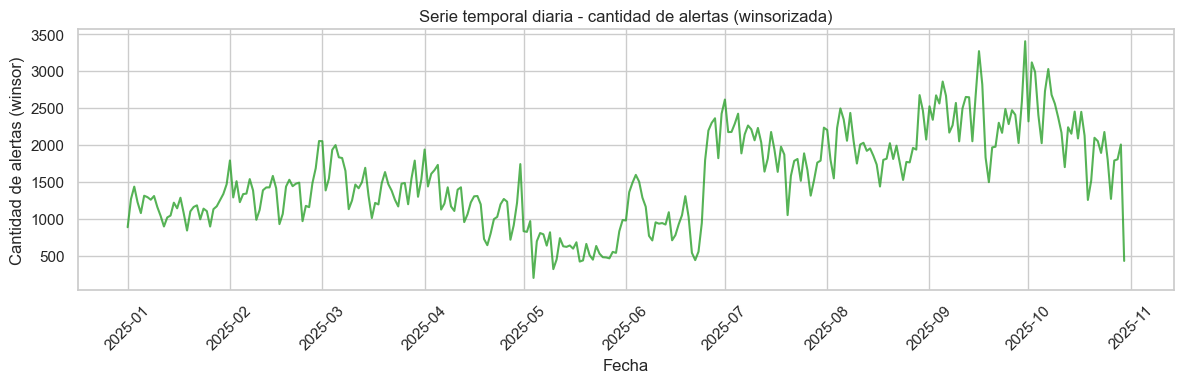

In [48]:
serie_alertas_win = (
    df_daily
    .groupby("FECHA")["CANTIDAD_ALERTA_WIN"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,4))
plt.plot(
    serie_alertas_win["FECHA"],
    serie_alertas_win["CANTIDAD_ALERTA_WIN"],
    label="Winsorizada",
    alpha=0.8,
    color="#2ca02c"
)

plt.title("Serie temporal diaria - cantidad de alertas (winsorizada)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de alertas (winsor)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [51]:
# Z-score sobre la columna winsorizada
z_scores = np.abs(stats.zscore(df_daily["CANTIDAD_ALERTA_WIN"].dropna()))
umbral = 3

outliers_z = np.where(z_scores > umbral)[0]

print("Total outliers detectados por Z-score:", len(outliers_z))


Total outliers detectados por Z-score: 770


In [52]:
df_daily.iloc[outliers_z][["FECHA", "ALERTA", "CANTIDAD_ALERTA", "CANTIDAD_ALERTA_WIN"]].head()

,FECHA,ALERTA,CANTIDAD_ALERTA,CANTIDAD_ALERTA_WIN
59,2025-01-01,ALERT_GOOGLE,248,180
60,2025-01-02,ALERT_GOOGLE,191,180
61,2025-01-03,ALERT_GOOGLE,183,180
62,2025-01-04,ALERT_GOOGLE,230,180
63,2025-01-05,ALERT_GOOGLE,212,180


In [53]:
q1 = df_daily["CANTIDAD_ALERTA_WIN"].quantile(0.25)
q3 = df_daily["CANTIDAD_ALERTA_WIN"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers_iqr = df_daily[
    (df_daily["CANTIDAD_ALERTA_WIN"] < lower) |
    (df_daily["CANTIDAD_ALERTA_WIN"] > upper)
]

print("Outliers detectados por IQR:", outliers_iqr.shape[0])


Outliers detectados por IQR: 1666


C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\numpy\lib\_function_base_impl.py:4809: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\numpy\lib\_function_base_impl.py:4809: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [54]:
outliers_iqr[["FECHA", "ALERTA", "CANTIDAD_ALERTA_WIN"]].head()


,FECHA,ALERTA,CANTIDAD_ALERTA_WIN
59,2025-01-01,ALERT_GOOGLE,180
60,2025-01-02,ALERT_GOOGLE,180
61,2025-01-03,ALERT_GOOGLE,180
62,2025-01-04,ALERT_GOOGLE,180
63,2025-01-05,ALERT_GOOGLE,180


In [58]:
X = df_daily[["CANTIDAD_ALERTA_WIN", "CLIENTES_UNICOS_WIN"]].dropna()

# Estandarizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DBSCAN multivariado

db = DBSCAN(
    eps=0.35,         # más sensible
    min_samples=4
).fit(X_scaled)

df_daily["OUTLIER_DBSCAN"] = 0
df_daily.loc[X.index, "OUTLIER_DBSCAN"] = (db.labels_ == -1).astype(int)

print("Outliers detectados por DBSCAN (multivariado):",
      df_daily["OUTLIER_DBSCAN"].sum())

# 3. Mostrar ejemplos

df_daily[df_daily["OUTLIER_DBSCAN"] == 1][[
    "FECHA", "ALERTA", "CANTIDAD_ALERTA_WIN", "CLIENTES_UNICOS_WIN"
]].head(10)

Outliers detectados por DBSCAN (multivariado): 3


,FECHA,ALERTA,CANTIDAD_ALERTA_WIN,CLIENTES_UNICOS_WIN
8277,2025-07-24,CMPA-06,104,26
8280,2025-07-27,CMPA-06,104,26
8282,2025-07-29,CMPA-06,107,28


In [61]:
df_out_compare = pd.DataFrame({
    "Zscore": 0,
    "IQR": 0,
    "DBSCAN": df_daily["OUTLIER_DBSCAN"].fillna(0),
}, index=df_daily.index)

df_out_compare.loc[outliers_z, "Zscore"] = 1
df_out_compare.loc[outliers_iqr.index, "IQR"] = 1

df_out_compare.sum()

Zscore     770
IQR       1666
DBSCAN       3
dtype: int64

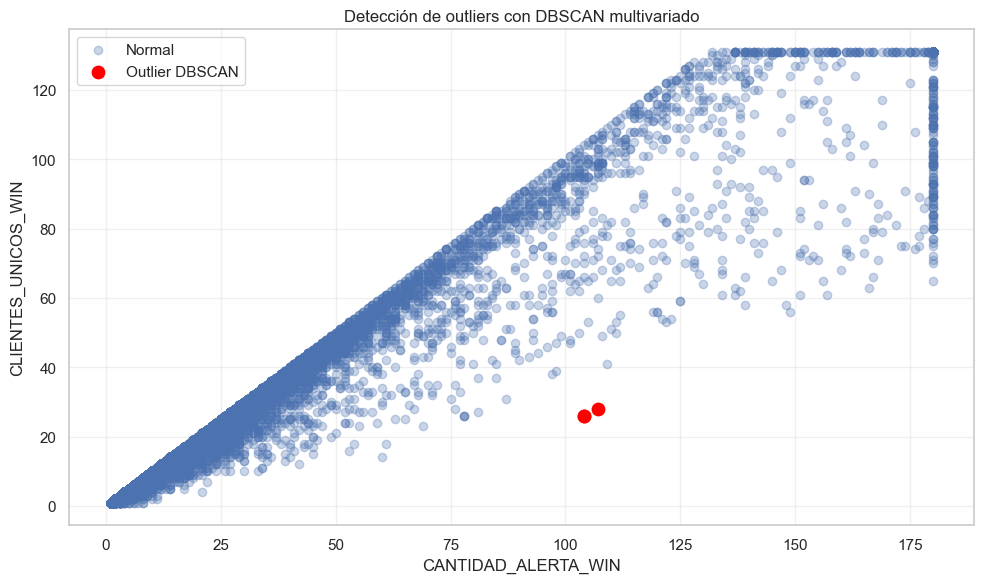

In [59]:
plt.figure(figsize=(10,6))

# Puntos normales
plt.scatter(
    df_daily[df_daily["OUTLIER_DBSCAN"] == 0]["CANTIDAD_ALERTA_WIN"],
    df_daily[df_daily["OUTLIER_DBSCAN"] == 0]["CLIENTES_UNICOS_WIN"],
    alpha=0.3,
    label="Normal",
    color="#4C72B0"
)

# Outliers
plt.scatter(
    df_daily[df_daily["OUTLIER_DBSCAN"] == 1]["CANTIDAD_ALERTA_WIN"],
    df_daily[df_daily["OUTLIER_DBSCAN"] == 1]["CLIENTES_UNICOS_WIN"],
    alpha=1,
    label="Outlier DBSCAN",
    color="red",
    s=80
)

plt.title("Detección de outliers con DBSCAN multivariado")
plt.xlabel("CANTIDAD_ALERTA_WIN")
plt.ylabel("CLIENTES_UNICOS_WIN")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

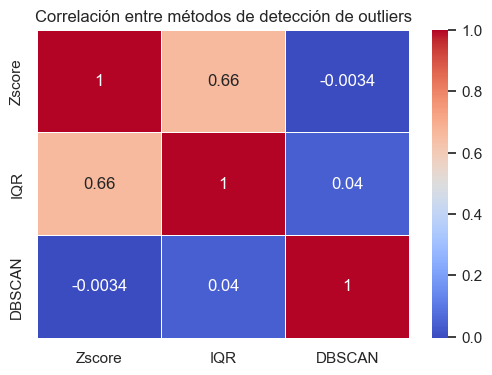

In [62]:

plt.figure(figsize=(6,4))
sns.heatmap(
    df_out_compare.corr(),
    annot=True,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlación entre métodos de detección de outliers")
plt.show()


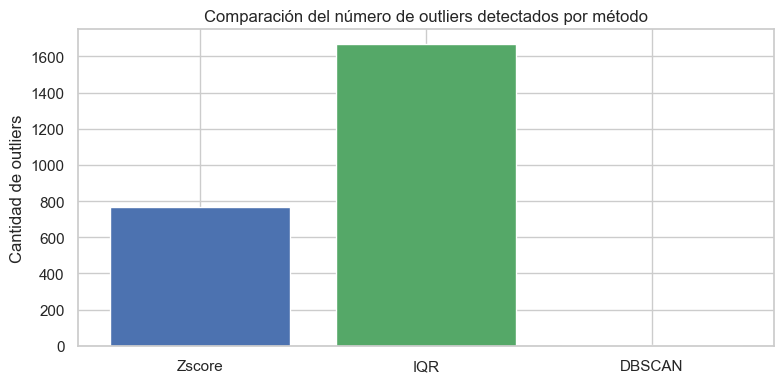

In [63]:
counts = df_out_compare.sum()

plt.figure(figsize=(8,4))
plt.bar(counts.index, counts.values, color=["#4C72B0","#55A868","red"])
plt.title("Comparación del número de outliers detectados por método")
plt.ylabel("Cantidad de outliers")
plt.tight_layout()
plt.show()


In [112]:
# Aseguramos copia ordenada por fecha
df_daily = df_daily.copy()
df_daily["FECHA"] = pd.to_datetime(df_daily["FECHA"])
df_daily_sorted = df_daily.sort_values("FECHA").reset_index(drop=True)

# Año / mes como columnas auxiliares
df_daily_sorted["ANIO"] = df_daily_sorted["FECHA"].dt.year
df_daily_sorted["MES"]  = df_daily_sorted["FECHA"].dt.month

# Condiciones de anomalía de negocio
cond_cmpa = (
    (df_daily_sorted["ALERTA"] == "CMPA-06") &
    (df_daily_sorted["ANIO"] == 2025) &
    (df_daily_sorted["MES"] == 7)     # JULIO
)

cond_bto = (
    (df_daily_sorted["ALERTA"] == "BTO-3") &
    (df_daily_sorted["ANIO"] == 2025) &
    (df_daily_sorted["MES"] == 3)     # MARZO
)

# Etiqueta final
df_daily_sorted["Y_FINAL"] = 0
df_daily_sorted.loc[cond_cmpa | cond_bto, "Y_FINAL"] = 1

df_daily_sorted["Y_FINAL"].value_counts()

Y_FINAL
0    14528
1       46
Name: count, dtype: int64

In [113]:
features = ["CANTIDAD_ALERTA_WIN", "CLIENTES_UNICOS_WIN"]

X = df_daily_sorted[features].values
y = df_daily_sorted["Y_FINAL"].values

n = len(X)
train_end = int(n * 0.7)
val_end   = int(n * 0.85)

X_train, y_train = X[:train_end],      y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:],        y[val_end:]

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("Test :", X_test.shape,  y_test.shape)


Train: (10201, 2) (10201,)
Val  : (2186, 2) (2186,)
Test : (2187, 2) (2187,)


In [114]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    f1_score, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

def evaluar_modelo(y_true, scores, threshold=0.5, nombre="modelo"):
    """
    y_true: etiquetas reales (0/1)
    scores: score continuo (más alto = más anómalo)
    threshold: umbral de corte. 0.2 significa "días con score >= 0.2 son anómalos"
    """
    import numpy as np

    y_pred = (scores >= threshold).astype(int)

    # AUCs
    try:
        roc_auc = roc_auc_score(y_true, scores)
    except Exception:
        roc_auc = np.nan

    try:
        pr_auc = average_precision_score(y_true, scores)
    except Exception:
        pr_auc = np.nan

    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== Evaluación {nombre} ===")
    print("Threshold:", threshold)
    print("ROC-AUC :", roc_auc)
    print("PR-AUC  :", pr_auc)
    print("F1      :", f1)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))

    # Curvas solo si hay ambas clases
    if len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, scores)
        prec, rec, _ = precision_recall_curve(y_true, scores)

        fig, ax = plt.subplots(1, 2, figsize=(10,4))
        ax[0].plot(fpr, tpr)
        ax[0].set_title(f"ROC - {nombre}")
        ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")

        ax[1].plot(rec, prec)
        ax[1].set_title(f"PRC - {nombre}")
        ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")

        plt.tight_layout()
        plt.show()
    else:
        print("Solo hay una clase en y_true: no se grafican ROC/PRC.")

    return roc_auc, pr_auc, f1


In [115]:
# se entrena con días normales (y=0)
X_train_norm = X_train[y_train == 0]

iso = IsolationForest(
    n_estimators=200,
    contamination=0.02,
    random_state=42,
    n_jobs=-1
)
iso.fit(X_train_norm)

# Scores (invertimos decision_function para que: mayor = más anómalo)
scores_train_if = -iso.decision_function(X_train)
scores_val_if   = -iso.decision_function(X_val)
scores_test_if  = -iso.decision_function(X_test)

# Threshold tipo "20% más anómalo" → percentil 80
threshold_if = np.percentile(scores_val_if, 80)
print("Threshold IF (top 20%):", threshold_if)

auc_if, pr_if, f1_if = evaluar_modelo(
    y_test, scores_test_if, threshold_if, nombre="Isolation Forest"
)


Threshold IF (top 20%): -0.14693546769992438

=== Evaluación Isolation Forest ===
Threshold: -0.14693546769992438
ROC-AUC : nan
PR-AUC  : 0.0
F1      : 0.0

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.824     0.903      2187
           1      0.000     0.000     0.000         0

    accuracy                          0.824      2187
   macro avg      0.500     0.412     0.452      2187
weighted avg      1.000     0.824     0.903      2187

Matriz de confusión:
[[1802  385]
 [   0    0]]
Solo hay una clase en y_true: no se grafican ROC/PRC.


C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 714 (2.79 KB)

 Trainable params: 714 (2.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6289 - val_loss: 0.1959
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383 - val_loss: 0.0160
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - val_loss: 0.0134
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - val_loss: 0.0106
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8587e-04 - val_loss: 5.8038e-04
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7876e-04 - val_loss: 3.6605e-04
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8786e-04 - val_loss: 2.9985e-04
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4345e-04 - val_loss: 2.5520e-04
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 

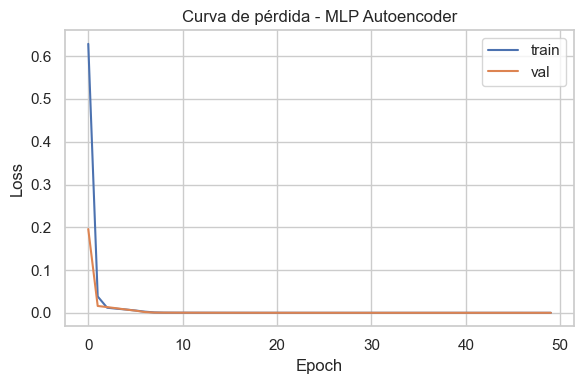

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
Threshold MLP (top 20% error): 3.595289338908403e-06

=== Evaluación MLP Autoencoder ===
Threshold: 3.595289338908403e-06
ROC-AUC : nan
PR-AUC  : 0.0
F1      : 0.0

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.750     0.857      2187
           1      0.000     0.000     0.000         0

    accuracy                          0.750      2187
   macro avg      0.500     0.375     0.429      2187
weighted avg      1.000     0.750     0.857      2187

Matriz de confusión:
[[1641  546]
 [   0    0]]
Solo hay una clase en y_true: no se grafican ROC/PRC.


C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [116]:
# Escalamos
scaler_mlp = StandardScaler()
X_train_norm = X_train[y_train == 0]
scaler_mlp.fit(X_train_norm)

X_train_s = scaler_mlp.transform(X_train)
X_val_s   = scaler_mlp.transform(X_val)
X_test_s  = scaler_mlp.transform(X_test)

input_dim = X_train_s.shape[1]
encoding_dim = 8

mlp_ae = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(encoding_dim, activation="relu", name="bottleneck"),
    layers.Dense(32, activation="relu"),
    layers.Dense(input_dim, activation="linear")
])

mlp_ae.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

mlp_ae.summary()

hist_mlp = mlp_ae.fit(
    X_train_s[y_train == 0],        # solo normales
    X_train_s[y_train == 0],
    epochs=50,
    batch_size=128,
    validation_data=(X_val_s[y_val == 0], X_val_s[y_val == 0]),
    verbose=1
)

# Curva de pérdida
plt.figure(figsize=(6,4))
plt.plot(hist_mlp.history["loss"], label="train")
plt.plot(hist_mlp.history["val_loss"], label="val")
plt.title("Curva de pérdida - MLP Autoencoder")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.show()

# Error de reconstrucción
recon_val_mlp  = mlp_ae.predict(X_val_s)
err_val_mlp    = np.mean((X_val_s - recon_val_mlp)**2, axis=1)

recon_test_mlp = mlp_ae.predict(X_test_s)
err_test_mlp   = np.mean((X_test_s - recon_test_mlp)**2, axis=1)

# Threshold p80 (20% días más “raros” entre val)
threshold_mlp = np.percentile(err_val_mlp, 80)
print("Threshold MLP (top 20% error):", threshold_mlp)

auc_mlp, pr_mlp, f1_mlp = evaluar_modelo(
    y_test, err_test_mlp, threshold_mlp, nombre="MLP Autoencoder"
)

In [117]:
def crear_secuencias(X_seg, y_seg, window):
    X_out, y_out = [], []
    for i in range(window, len(X_seg)):
        X_out.append(X_seg[i-window:i, :])
        y_out.append(y_seg[i])  # etiqueta del último día
    return np.array(X_out), np.array(y_out)


In [118]:
window = 7
# usamos X ya ordenado (df_daily_sorted)
X_all = df_daily_sorted[features].values
y_all = df_daily_sorted["Y_FINAL"].values

X_all_s = scaler_mlp.transform(X_all)   # reusamos scaler_mlp

X_seq, y_seq = crear_secuencias(X_all_s, y_all, window)

# volvemos a hacer split pero ahora sobre secuencias
n_seq = len(X_seq)
train_end_seq = int(n_seq * 0.7)
val_end_seq   = int(n_seq * 0.85)

X_train_seq, y_train_seq = X_seq[:train_end_seq],      y_seq[:train_end_seq]
X_val_seq,   y_val_seq   = X_seq[train_end_seq:val_end_seq], y_seq[train_end_seq:val_end_seq]
X_test_seq,  y_test_seq  = X_seq[val_end_seq:],        y_seq[val_end_seq:]

print("Train seq:", X_train_seq.shape, y_train_seq.shape)
print("Val seq  :", X_val_seq.shape,   y_val_seq.shape)
print("Test seq :", X_test_seq.shape,  y_test_seq.shape)


Train seq: (10196, 7, 2) (10196,)
Val seq  : (2185, 7, 2) (2185,)
Test seq : (2186, 7, 2) (2186,)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 7, 64)          │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 7, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 7, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 7, 2)           │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,850 (245.51 KB)

 Trainable params: 62,850 (245.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.7948 - val_loss: 0.9376
Epoch 2/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5415 - val_loss: 0.4909
Epoch 3/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3007 - val_loss: 0.3760
Epoch 4/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2264 - val_loss: 0.3045
Epoch 5/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1900 - val_loss: 0.2388
Epoch 6/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1587 - val_loss: 0.2102
Epoch 7/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1337 - val_loss: 0.1609
Epoch 8/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1116 - val_loss: 0.1400
Epoch 9/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0984 - val_loss: 0.1274
Epoch 10/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0859 - val_loss: 0.1141
Epoch 11/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0763 - val_loss: 0.0944
Epoch 12/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

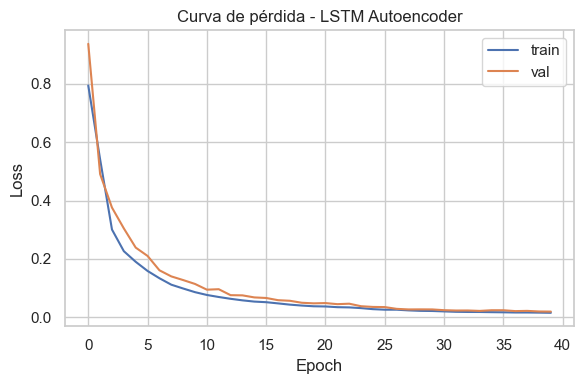

In [119]:

ventana   = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

X_train_seq_norm = X_train_seq[y_train_seq == 0]

inputs = layers.Input(shape=(ventana, n_features))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(32, return_sequences=False)(x)
encoded = layers.RepeatVector(ventana)(x)
x = layers.LSTM(32, return_sequences=True)(encoded)
x = layers.LSTM(64, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(n_features))(x)

lstm_ae = models.Model(inputs, outputs)
lstm_ae.compile(optimizer="adam", loss="mse")
lstm_ae.summary()

hist_lstm = lstm_ae.fit(
    X_train_seq_norm,
    X_train_seq_norm,
    epochs=40,
    batch_size=64,
    validation_data=(
        X_val_seq[y_val_seq == 0],
        X_val_seq[y_val_seq == 0]
    ),
    verbose=1
)

plt.figure(figsize=(6,4))
plt.plot(hist_lstm.history["loss"], label="train")
plt.plot(hist_lstm.history["val_loss"], label="val")
plt.title("Curva de pérdida - LSTM Autoencoder")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.tight_layout(); plt.show()


In [120]:
# Error de reconstrucción
recon_val_lstm  = lstm_ae.predict(X_val_seq)
err_val_lstm    = np.mean((X_val_seq - recon_val_lstm)**2, axis=(1,2))

recon_test_lstm = lstm_ae.predict(X_test_seq)
err_test_lstm   = np.mean((X_test_seq - recon_test_lstm)**2, axis=(1,2))

threshold_lstm = np.percentile(err_val_lstm, 80)  # top 20%
print("Threshold LSTM (top 20% error):", threshold_lstm)

auc_lstm, pr_lstm, f1_lstm = evaluar_modelo(
    y_test_seq, err_test_lstm, threshold_lstm, nombre="LSTM Autoencoder"
)


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Threshold LSTM (top 20% error): 0.03362459183623335

=== Evaluación LSTM Autoencoder ===
Threshold: 0.03362459183623335
ROC-AUC : nan
PR-AUC  : 0.0
F1      : 0.0

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.860     0.925      2186
           1      0.000     0.000     0.000         0

    accuracy                          0.860      2186
   macro avg      0.500     0.430     0.463      2186
weighted avg      1.000     0.860     0.925      2186

Matriz de confusión:
[[1881  305]
 [   0    0]]
Solo hay una clase en y_true: no se grafican ROC/PRC.


C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [121]:
resultados = pd.DataFrame([
    ["Isolation Forest", auc_if,  pr_if,  f1_if ],
    ["MLP Autoencoder",  auc_mlp, pr_mlp, f1_mlp],
    ["LSTM Autoencoder", auc_lstm, pr_lstm, f1_lstm],
], columns=["Modelo", "ROC-AUC", "PR-AUC", "F1"])

resultados.sort_values(by="F1", ascending=False)


,Modelo,ROC-AUC,PR-AUC,F1
0,Isolation Forest,NaN,0.0,0.0
1,MLP Autoencoder,NaN,0.0,0.0
2,LSTM Autoencoder,NaN,0.0,0.0


In [124]:
df_daily["FECHA"] = pd.to_datetime(df_daily["FECHA"])

df_daily["ANIO"] = df_daily["FECHA"].dt.year
df_daily["MES_NUM"] = df_daily["FECHA"].dt.month


In [125]:
# todo como normal
df_daily["Y_FINAL"] = 0

# Anomalía 1: CMPA-06 en julio 2025
mask_cmpa = (
    (df_daily["ALERTA"] == "CMPA-06") &
    (df_daily["ANIO"] == 2025) &
    (df_daily["MES_NUM"] == 7)
)

# Anomalía 2: BTO-3 en marzo 2025
mask_bto = (
    (df_daily["ALERTA"] == "BTO-3") &
    (df_daily["ANIO"] == 2025) &
    (df_daily["MES_NUM"] == 3)
)

df_daily.loc[mask_cmpa | mask_bto, "Y_FINAL"] = 1

print(df_daily["Y_FINAL"].value_counts())
df_daily[df_daily["Y_FINAL"] == 1].head()


Y_FINAL
0    14528
1       46
Name: count, dtype: int64


,level_0,index,ALERTA,FECHA,CANTIDAD_ALERTA,TOTAL_CLIENTES,CLIENTES_UNICOS,TIPO,FRECUENCIA,CANTIDAD_ALERTA_WIN,CLIENTES_UNICOS_WIN,TOTAL_CLIENTES_WIN,OUTLIER_DBSCAN,PCT_ALERTAS_POR_CLIENTE,ANOMALIA_BIZ,Y_FINAL,ANIO,MES_NUM
5608,5608,5608,BTO-3,2025-03-01,29,29,23,2,D,29,23,29,0,1.260870,1,1,2025,3
5609,5609,5609,BTO-3,2025-03-02,21,21,18,2,D,21,18,21,0,1.166667,1,1,2025,3
5610,5610,5610,BTO-3,2025-03-03,29,29,24,2,D,29,24,29,0,1.208333,1,1,2025,3
5611,5611,5611,BTO-3,2025-03-04,27,27,22,2,D,27,22,27,0,1.227273,1,1,2025,3
5612,5612,5612,BTO-3,2025-03-05,34,34,28,2,D,34,28,34,0,1.214286,1,1,2025,3


In [126]:
features = ["CANTIDAD_ALERTA_WIN", "CLIENTES_UNICOS_WIN"]

# Ordenamos por fecha
df_daily_sorted = df_daily.sort_values("FECHA")

X = df_daily_sorted[features].values
y = df_daily_sorted["Y_FINAL"].values


In [127]:
n = len(X)
train_end = int(n * 0.7)
val_end   = int(n * 0.85)

X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("Test :", X_test.shape,  y_test.shape)


Train: (10201, 2) (10201,)
Val  : (2186, 2) (2186,)
Test : (2187, 2) (2187,)


In [129]:
# err_val_lstm contiene el error de reconstrucción en VAL
# y_val_seq las etiquetas de esas secuencias

err_val_norm_lstm = err_val_lstm[y_val_seq == 0]

# top 20% de error => percentil 80
threshold_lstm = np.percentile(err_val_norm_lstm, 80)
print("Threshold LSTM (top 20% error):", threshold_lstm)


Threshold LSTM (top 20% error): 0.03362459183623335



=== Evaluación LSTM Autoencoder (threshold=0.0336) ===
ROC-AUC: nan
PR-AUC : 0.0

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.860     0.925      2186
           1      0.000     0.000     0.000         0

    accuracy                          0.860      2186
   macro avg      0.500     0.430     0.463      2186
weighted avg      1.000     0.860     0.925      2186

Matriz de confusión:
[[1881  305]
 [   0    0]]


C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


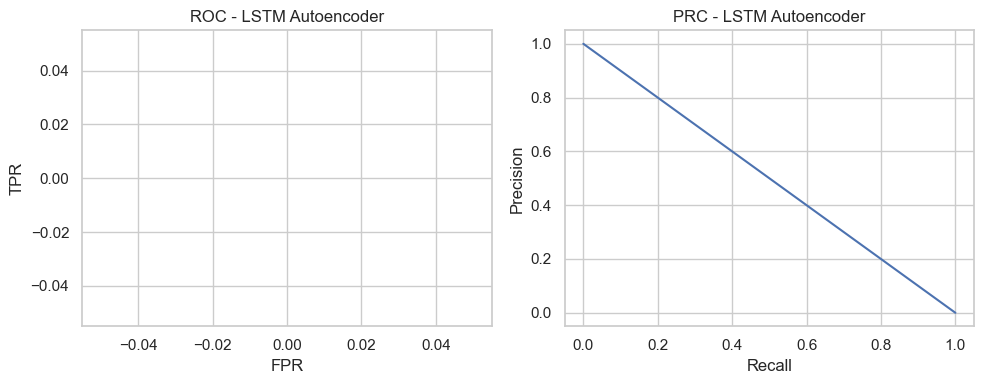

In [130]:
roc_lstm, pr_lstm, f1_lstm = evaluar_modelo(
    y_test_seq,  # o y_all_seq si evaluas global
    err_test_lstm,  # o err_all_lstm
    threshold=threshold_lstm,
    nombre="LSTM Autoencoder"
)


In [133]:
def evaluar_modelo(y_true, scores, threshold=0.5, nombre="modelo"):
    """
    Evalúa un modelo de detección de anomalías y retorna métricas clave.
    
    Retorna:
        roc_auc, pr_auc, f1
    """
    y_pred = (scores >= threshold).astype(int)

    print(f"\n=== Evaluación {nombre} (threshold={threshold:.4f}) ===")

    # Inicializamos en NaN
    roc_auc = float("nan")
    pr_auc = float("nan")

    # Intentar calcular AUC
    try:
        roc_auc = roc_auc_score(y_true, scores)
        pr_auc = average_precision_score(y_true, scores)
        print("ROC-AUC:", roc_auc)
        print("PR-AUC :", pr_auc)
    except ValueError:
        print("No ROC/PR-AUC NO disponibles (solo una clase en y_true)")

    # Classification report
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3))

    # Matriz de confusión
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))

    # Calcular F1
    try:
        f1 = f1_score(y_true, y_pred)
    except:
        f1 = float("nan")

    # Graficar curvas solo si hay ambas clases
    try:
        fpr, tpr, _ = roc_curve(y_true, scores)
        prec, rec, _ = precision_recall_curve(y_true, scores)

        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        # ROC
        ax[0].plot(fpr, tpr)
        ax[0].set_title(f"ROC - {nombre}")
        ax[0].set_xlabel("FPR")
        ax[0].set_ylabel("TPR")

        # PRC
        ax[1].plot(rec, prec)
        ax[1].set_title(f"PRC - {nombre}")
        ax[1].set_xlabel("Recall")
        ax[1].set_ylabel("Precision")

        plt.tight_layout()
        plt.show()

    except ValueError:
        print("No es posible graficar ROC/PR porque solo hay una clase en y_true.")

    return roc_auc, pr_auc, f1


=== Evaluación Isolation Forest (threshold=-0.1469) ===
ROC-AUC: nan
PR-AUC : 0.0

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.824     0.903      2187
           1      0.000     0.000     0.000         0

    accuracy                          0.824      2187
   macro avg      0.500     0.412     0.452      2187
weighted avg      1.000     0.824     0.903      2187

Matriz de confusión:
[[1802  385]
 [   0    0]]


C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _wa

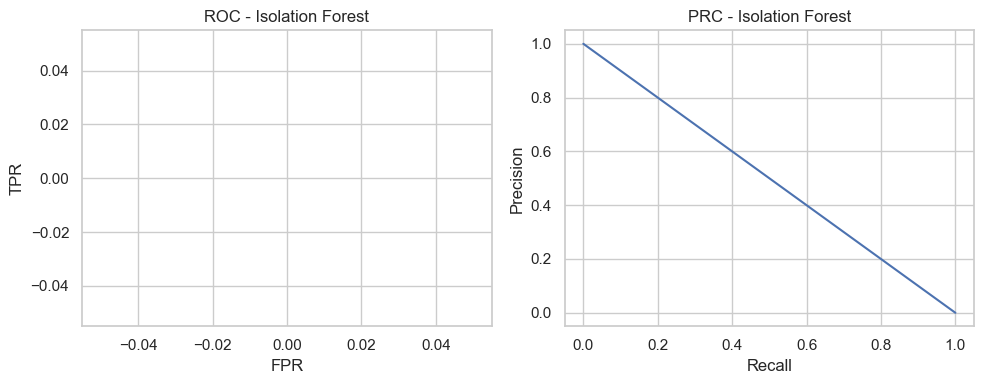


=== Evaluación MLP Autoencoder (threshold=0.0000) ===
ROC-AUC: nan
PR-AUC : 0.0

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.750     0.857      2187
           1      0.000     0.000     0.000         0

    accuracy                          0.750      2187
   macro avg      0.500     0.375     0.429      2187
weighted avg      1.000     0.750     0.857      2187

Matriz de confusión:
[[1641  546]
 [   0    0]]


C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _wa

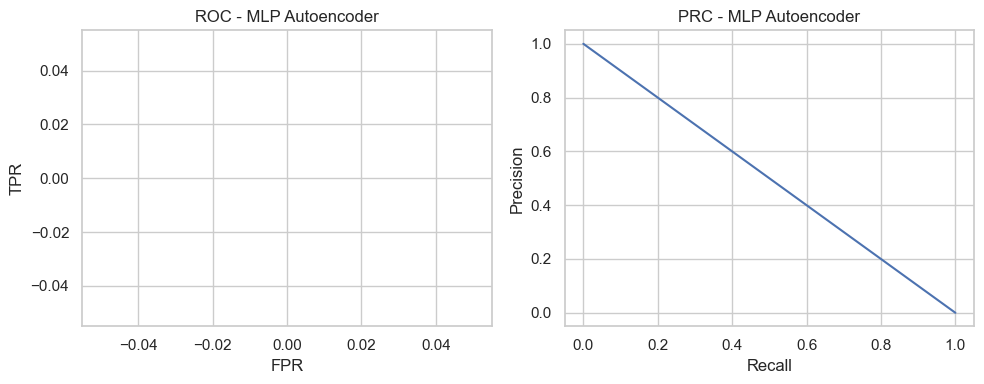


=== Evaluación LSTM Autoencoder (threshold=0.0336) ===
ROC-AUC: nan
PR-AUC : 0.0

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.860     0.925      2186
           1      0.000     0.000     0.000         0

    accuracy                          0.860      2186
   macro avg      0.500     0.430     0.463      2186
weighted avg      1.000     0.860     0.925      2186

Matriz de confusión:
[[1881  305]
 [   0    0]]


C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\gonza\anaconda3\envs\Alerta_IA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _wa

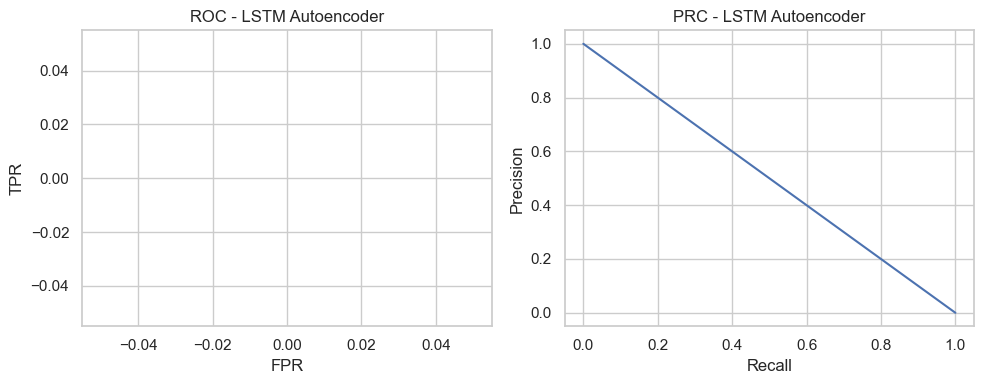

In [134]:
roc_if, pr_if, f1_if = evaluar_modelo(y_test, scores_test_if, threshold_if, "Isolation Forest")
roc_mlp, pr_mlp, f1_mlp = evaluar_modelo(y_test, err_test_mlp, threshold_mlp, "MLP Autoencoder")
roc_lstm, pr_lstm, f1_lstm = evaluar_modelo(y_test_seq, err_test_lstm, threshold_lstm, "LSTM Autoencoder")


In [135]:
resultados = pd.DataFrame([
    ["Isolation Forest", roc_if, pr_if, f1_if],
    ["MLP Autoencoder", roc_mlp, pr_mlp, f1_mlp],
    ["LSTM Autoencoder", roc_lstm, pr_lstm, f1_lstm],
], columns=["Modelo", "ROC-AUC", "PR-AUC", "F1"])

resultados.sort_values(by="F1", ascending=False)


,Modelo,ROC-AUC,PR-AUC,F1
0,Isolation Forest,NaN,0.0,0.0
1,MLP Autoencoder,NaN,0.0,0.0
2,LSTM Autoencoder,NaN,0.0,0.0
